In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.style.use('default')

## 1. Data preprocessing


In [2]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Change stock and split to adjust between splitting type and stock
stock = 2 # ITD
split = 2 # 90% train, 10% test

In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df = df[["time", "close"]]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df

,close
time,
2019-03-01,6900
2019-03-04,7100
2019-03-05,7100
2019-03-06,7170
2019-03-07,7170
...,...
2024-05-27,11300
2024-05-28,12050
2024-05-29,12600


In [5]:
df.shape

(1313, 1)

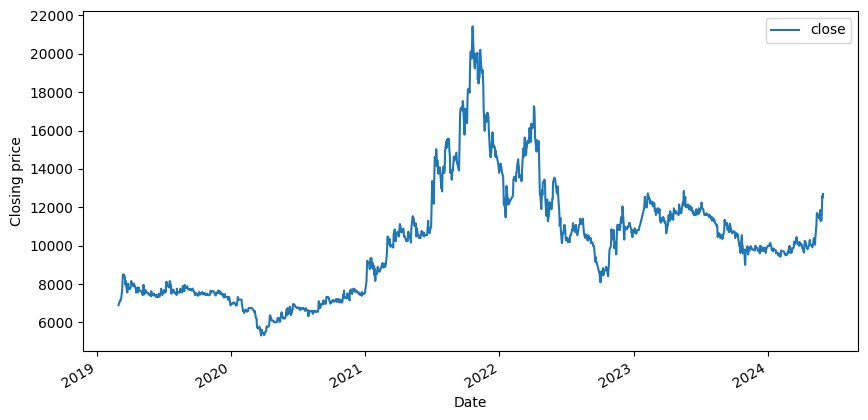

In [6]:
df.plot(figsize=(10, 5))
plt.ylabel("Closing price")
plt.xlabel("Date")
plt.show()

In [7]:
df = df.reset_index()["close"]
df

0        6900
1        7100
2        7100
3        7170
4        7170
        ...  
1308    11300
1309    12050
1310    12600
1311    12500
1312    12700
Name: close, Length: 1313, dtype: int64

In [8]:
# Normalize data between 0 and 1 because we using neural network model
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df).reshape(-1, 1))

## 2. Model training


### Create train set, test set and reshape them


In [9]:
# Defining the split size
train_size = int(split_type[split] * len(df_scaled))
test_size = len(df_scaled) - train_size

In [10]:
# Splitting data into train, test set
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

In [11]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, window_side):
    X, y = [], []

    for i in range(len(data) - window_side - 1):
        X.append(data[i : (i + window_side), 0])
        y.append(data[i + window_side, 0])

    return np.array(X), np.array(y)

In [12]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SIDE = 10

# Create X, y for train, test
X_train, y_train = create_dataset(train_data, WINDOW_SIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SIDE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1170, 10), (1170,), (121, 10), (121,))

In [13]:
# Reshape the dataset to suit the RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Start train model


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

# Initialize LSTM model
model = Sequential(
    [
        Input((X_train.shape[1], 1)),
        LSTM(64),
        Dense(1),  # activation default is linear
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer="adam", loss="mse", metrics=["mean_absolute_error"])

In [16]:
EPOCHS = 200
BATCH_SIZE = 32
VERBOSE = 1

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE
)

Epoch 1/200


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0602 - mean_absolute_error: 0.1858  
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0360
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0251
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0241
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0244    
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0222    
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0240
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0230    
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0232
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0223    
Epoch 11/200
37/37 ━━━━━━━━━━━━━━

### Predicting with test set


In [17]:
# Predict and convert the data back - because i reshaped between 0 and 1, so need to convert back
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


## 3. Model evaluation


In [18]:
# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0479e-04 - mean_absolute_error: 0.0075  
Test Loss: [0.00014651523088105023, 0.008590173907577991]


In [19]:
# Splitting data into train, test set again to evaluate, because i shaped the data between 0 to 1 to suit the model
train_data1 = df[:train_size]
test_data1 = df[train_size : train_size + test_size]

X_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [20]:
print(len(y_test))
print(len(y_test1))

121
132


In [21]:
# Evaluation
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
    mean_absolute_error as mae,
)


def evalute_model(y, y_pred):
    # Because i use the sliding window with the time_step value, so the length of 'y' and 'y predict' will difference
    min_len = min(len(y), len(y_pred))
    y = y[-min_len:]
    y_pred = y_pred[-min_len:]

    print(f"MSE: {mse(y, y_pred)}")
    print(f"RMSE: {np.sqrt(mse(y, y_pred))}")
    print(f"MAE: {mae(y, y_pred)}")
    print(f"MAPE: {mape(y, y_pred) * 100} %")

In [22]:
# So the result will change every time RUN ALL (build model again), because the model will take random start number.
# But it dont change much, the MAPE will less than 2 %(test set)
# Model evaluation on test set
print("Model evalution on test set")
evalute_model(y_test1, y_pred_test)

Model evalution on test set
MSE: 77714.58971461777
RMSE: 278.7733662217712
MAE: 186.64570958161158
MAPE: 1.7863107399847267 %


## 4. Forecast the next 30/60/90 days


In [23]:
def forecast(data, window_side, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_side:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side, num_features)
        x_forecast_reshaped = x_forecast.reshape(1, window_side, x_forecast.shape[1])
        # Predict the next day
        y = model.predict(x_forecast_reshaped)
        y_forecast.append(y[0][0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [24]:
y_pred_30_days = forecast(test_data, 5, 30)

# Assuming y_pred_30_days is a 1D array
y_pred_30_days = np.array(y_pred_30_days).reshape(-1, 1)

# Inverse transform y_pred_30_days
y_pred_30_days = scaler.inverse_transform(y_pred_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━

In [25]:
y_pred_30_days

array([[12691.235 ],
       [12673.746 ],
       [12688.798 ],
       [12687.156 ],
       [12688.674 ],
       [12688.466 ],
       [12688.615 ],
       [12688.591 ],
       [12688.606 ],
       [12688.604 ],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045],
       [12688.6045]], dtype=float32)

### Continute predict the next 60/90 days


In [26]:
y_pred_60_days = forecast(test_data, 5, 60)
y_pred_60_days = np.array(y_pred_60_days).reshape(-1, 1)
y_pred_60_days = scaler.inverse_transform(y_pred_60_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [27]:
y_pred_90_days = forecast(test_data, 5, 90)
y_pred_90_days = np.array(y_pred_90_days).reshape(-1, 1)
y_pred_90_days = scaler.inverse_transform(y_pred_90_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

### Plot the data


In [28]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Closing Price")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SIDE : len(y_pred_test) + WINDOW_SIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_pred_test,
        label="Predicted Test",
        linestyle="--",
    )

    # Predict the next 30/60/90 days
    plt.plot(
        test_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Next {days} Days",
        linestyle="--",
    )

    plt.title(f"Forecast {stock_name[stock]} Stock Closing Price Using LSTM")
    plt.legend()
    plt.show()

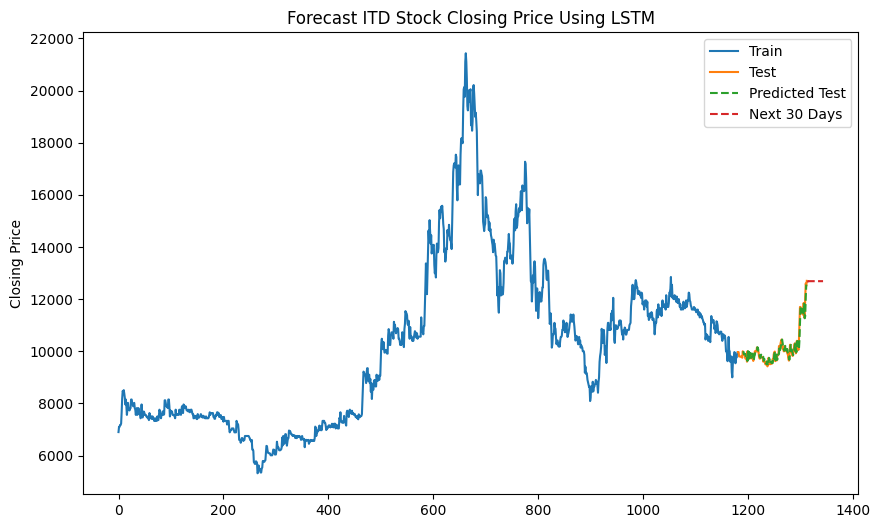

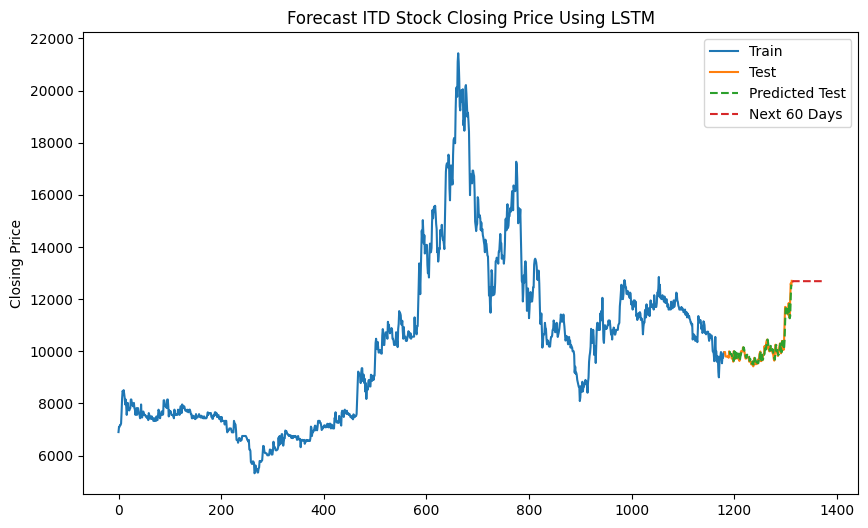

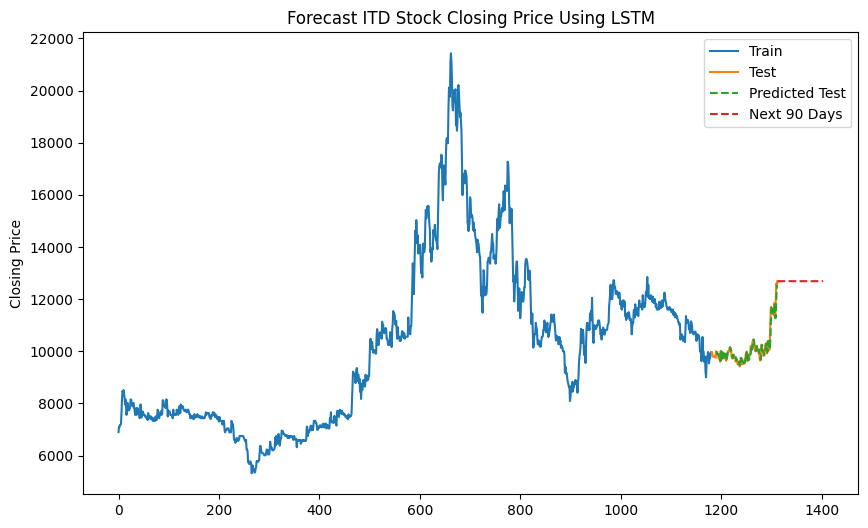

In [29]:
draw_plot(y_pred_30_days, 30)
draw_plot(y_pred_60_days, 60)
draw_plot(y_pred_90_days, 90)
